In [4]:
""""
Gold PRICE PREDICTION - SIMPLE LSTM MODEL

Steps:
1. Download dat from yfinance
2. Prepare data fro LSTM
3. Build simple LSTM model
4. Train and evaluate
5. Measure KPI (MAPE < 2%)
6. Save model for Flask API

"""

'"\nGold PRICE PREDICTION - SIMPLE LSTM MODEL\n\nSteps:\n1. Download dat from yfinance\n2. Prepare data fro LSTM\n3. Build simple LSTM model\n4. Train and evaluate\n5. Measure KPI (MAPE < 2%)\n6. Save model for Flask API\n\n'

In [5]:
#Step 1: Install and Import Libararies

import os
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import joblib
import warnings
warnings.filterwarnings('ignore')
from datetime import datetime

print("✓ All libraries imported successfully")
print(f"TensorFlow version: {tf.__version__}")

✓ All libraries imported successfully
TensorFlow version: 2.20.0


In [6]:
# Save to CSV (for backup/reference) with timestamp and keep only the latest
import glob
from datetime import datetime

# Download gold price data from yfinance (5 years)
data = yf.download('GC=F', period='5y')

os.makedirs('../data/raw', exist_ok=True)
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
csv_path = f'../data/raw/gold_raw_5y_{timestamp}.csv'
data.to_csv(csv_path)
print(f"\n✓ Saved raw data to: {csv_path}")
# Delete old gold_raw_5y_*.csv files except the latest
csv_files = sorted(glob.glob('../data/raw/gold_raw_5y_*.csv'))
for old_file in csv_files[:-1]:
    try:
        os.remove(old_file)
        print(f"Deleted old CSV: {old_file}")
    except Exception as e:
        print(f"Could not delete {old_file}: {e}")

[*********************100%***********************]  1 of 1 completed


✓ Saved raw data to: ../data/raw/gold_raw_5y_20260107_154610.csv
Deleted old CSV: ../data/raw\gold_raw_5y_20260107_141837.csv


In [7]:
# Check for missing values
print(f"\nMissing values: {data.isnull().sum().sum()}")


Missing values: 0


In [8]:
# Step 3: Prepare data for LSTM
print("STEP 3: Preparing Data for LSTM")

# Use only Close price for simplicity
prices = data['Close'].values.reshape(-1, 1)

print(f"Original data shape: {prices.shape}")
print(f"Price range: ${prices.min():.2f} - ${prices.max():.2f}")

STEP 3: Preparing Data for LSTM
Original data shape: (1258, 1)
Price range: $1623.30 - $4529.10


In [9]:
# Scale data to 0-1 range (LSTM works better with normalized data)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(prices)

print(f"✓ Data scaled to range: {scaled_data.min():.3f} - {scaled_data.max():.3f}")

✓ Data scaled to range: 0.000 - 1.000


In [11]:
# STEP 5: Create Sequences for LSTM
print("STEP 5: Creating Sequences for LSTM")

# Create sequences for LSTM
# LSTM needs to look at past N days to predict the next day
LOOKBACK_DAYS = 20  # Balanced: good MAPE (1.30%) + best direction accuracy (52.2%)
LSTM_UNITS = 100    # Optimized from hyperparameter tuning
LSTM_EPOCHS = 60    # Balanced config for better direction accuracy

def create_sequences(data, lookback):
    """
    Create sequences for LSTM training
    
    Example: If lookback=20
    X = [day 1-20 prices] → y = day 21 price
    X = [day 2-21 prices] → y = day 22 price
    """
    X, y = [], []
    for i in range(lookback, len(data)):
        X.append(data[i-lookback:i, 0])  # Past 20 days
        y.append(data[i, 0])              # Next day (target)
    return np.array(X), np.array(y)

X, y = create_sequences(scaled_data, LOOKBACK_DAYS)

print(f"\n✓ Created sequences:")
print(f"  X shape: {X.shape} (samples, lookback_days)")

print(f"  y shape: {y.shape} (samples,)")
print(f"  Total sequences: {len(X)}")

STEP 5: Creating Sequences for LSTM

✓ Created sequences:
  X shape: (1238, 20) (samples, lookback_days)
  y shape: (1238,) (samples,)
  Total sequences: 1238


In [12]:
# Split into train/test (80/20)
split_idx = int(len(X) * 0.8)
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

In [13]:
# Reshape for LSTM: (samples, timesteps, features)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

print(f"\n✓ Train/Test Split:")
print(f"  Train: {X_train.shape[0]} samples")
print(f"  Test: {X_test.shape[0]} samples")
print(f"  Final shapes for LSTM:")
print(f"    X_train: {X_train.shape} (samples, timesteps, features)")
print(f"    X_test: {X_test.shape}")


✓ Train/Test Split:
  Train: 990 samples
  Test: 248 samples
  Final shapes for LSTM:
    X_train: (990, 20, 1) (samples, timesteps, features)
    X_test: (248, 20, 1)


In [14]:
# STEP 4: BUILD SIMPLE LSTM MODEL
print("STEP 4: Building LSTM Model")

# LSTM model with optimized hyperparameters
model = Sequential([
    # First LSTM layer - 100 units (optimized)
    LSTM(units=LSTM_UNITS, return_sequences=True, input_shape=(X_train.shape[1], 1)),
    Dropout(0.2),  # Prevent overfitting
    
    # Second LSTM layer - 100 units (optimized)
    LSTM(units=LSTM_UNITS, return_sequences=False),
    Dropout(0.2),
    
    # Output layer
    Dense(units=1)  # Predict one value (next day price)
])

# Compile model
model.compile(optimizer='adam', loss='mean_squared_error')

print("✓ Model created")
print("\nModel Summary:")
model.summary()

STEP 4: Building LSTM Model
✓ Model created

Model Summary:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 20, 100)        │        40,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 20, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 100)            │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 121,301 (473.83 KB)

 Trainable params: 121,301 (473.83 KB)

 Non-trainable params: 0 (0.00 B)

In [15]:
# STEP 5: TRAIN MODEL WITH MLFLOW TRACKING
print("STEP 5: Training Model with MLflow Tracking")

import mlflow
mlflow.set_tracking_uri("file:///" + os.path.abspath("../mlruns").replace("\\", "/"))
mlflow.set_experiment("Gold_Price_LSTM")

with mlflow.start_run():
    # Log parameters (optimized from hyperparameter tuning)
    mlflow.log_param("lookback_days", LOOKBACK_DAYS)
    mlflow.log_param("lstm_units_1", LSTM_UNITS)
    mlflow.log_param("lstm_units_2", LSTM_UNITS)
    mlflow.log_param("dropout", 0.2)
    mlflow.log_param("epochs", LSTM_EPOCHS)
    mlflow.log_param("batch_size", 32)
    
    # Train model
    history = model.fit(
        X_train, y_train,
        epochs=LSTM_EPOCHS,
        batch_size=32,
        validation_split=0.1,
        verbose=1
    )
    
    # Log metrics
    predictions_scaled = model.predict(X_test, verbose=0)
    predictions = scaler.inverse_transform(predictions_scaled)
    actual = scaler.inverse_transform(y_test.reshape(-1, 1))
    mape = mean_absolute_percentage_error(actual, predictions) * 100
    rmse = np.sqrt(mean_squared_error(actual, predictions))
    mae = np.mean(np.abs(actual - predictions))
    mlflow.log_metric("MAPE", mape)
    mlflow.log_metric("RMSE", rmse)
    mlflow.log_metric("MAE", mae)
    
    # Log model
    mlflow.keras.log_model(model, "model")
    
    print(f"\n✓ Training complete!")
    print(f"  MAPE: {mape:.2f}%")
    print(f"  RMSE: ${rmse:.2f}")
    print(f"  MAE: ${mae:.2f}")

STEP 5: Training Model with MLflow Tracking
Epoch 1/60
28/28 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - loss: 0.0017 - val_loss: 3.2290e-04
Epoch 2/60
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 2.9969e-04 - val_loss: 3.9316e-04
Epoch 3/60
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 2.3585e-04 - val_loss: 2.8631e-04
Epoch 4/60
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 2.3164e-04 - val_loss: 2.8619e-04
Epoch 5/60
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 2.4775e-04 - val_loss: 7.5693e-04
Epoch 6/60
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 2.1859e-04 - val_loss: 6.5567e-04
Epoch 7/60
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 2.0329e-04 - val_loss: 4.2762e-04
Epoch 8/60
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 1.9028e-04 - val_loss: 2.6610e-04
Epoch 9/60
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 2.1064e-04 - val_loss: 5.7861e-04
Epoch 10/60
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 1.8755e-04 - val_loss: 2.3124e-04
Epoch 11/60
28/28 ━━━━━━━━━━━

2026/01/07 15:49:10 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2026/01/07 15:49:10 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2026/01/07 15:49:27 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



✓ Training complete!
  MAPE: 1.73%
  RMSE: $79.50
  MAE: $61.21


In [16]:
# STEP 6: MAKE PREDICTIONS
print("STEP 6: Making Predictions")

# Predict on test set
predictions_scaled = model.predict(X_test, verbose=0)

# Convert back to original price scale
predictions = scaler.inverse_transform(predictions_scaled)
actual = scaler.inverse_transform(y_test.reshape(-1, 1))

print(f"✓ Made {len(predictions)} predictions")
print(f"\nSample predictions vs actual:")
print(f"{'Day':<8} {'Actual':<12} {'Predicted':<12} {'Error':<12}")
print("-" * 50)
for i in range(min(10, len(predictions))):
    error = abs(actual[i][0] - predictions[i][0])
    print(f"{i+1:<8} ${actual[i][0]:<11.2f} ${predictions[i][0]:<11.2f} ${error:<11.2f}")

STEP 6: Making Predictions
✓ Made 248 predictions

Sample predictions vs actual:
Day      Actual       Predicted    Error       
--------------------------------------------------
1        $2677.50     $2723.78     $46.28      
2        $2712.50     $2719.80     $7.30       
3        $2746.40     $2727.02     $19.38      
4        $2744.30     $2748.56     $4.26       
5        $2755.00     $2767.80     $12.80      
6        $2767.60     $2783.35     $15.75      
7        $2763.10     $2796.42     $33.32      
8        $2777.30     $2801.98     $24.68      
9        $2737.50     $2807.46     $69.96      
10       $2766.80     $2796.19     $29.39      


In [17]:
# STEP 7: CALCULATE KPI (MAPE < 2%)
print("STEP 7: MEASURING KPI - MAPE < 2%")

# Calculate metrics
mape = mean_absolute_percentage_error(actual, predictions) * 100
rmse = np.sqrt(mean_squared_error(actual, predictions))
mae = np.mean(np.abs(actual - predictions))

# Direction accuracy (did we predict up/down correctly?)
actual_direction = (actual[1:] > actual[:-1]).astype(int)
pred_direction = (predictions[1:] > predictions[:-1]).astype(int)
direction_accuracy = (actual_direction == pred_direction).mean() * 100


print(f"\n🎯 MODEL PERFORMANCE METRICS:")
print("=" * 50)
print(f"MAPE (Mean Absolute Percentage Error): {mape:.2f}%")
print(f"Target: < 2.00%")
print(f"Status: {'✅ PASS' if mape < 2.0 else '⚠️ NEEDS IMPROVEMENT'}")
print("-" * 50)
print(f"RMSE (Root Mean Squared Error): ${rmse:.2f}")
print(f"MAE (Mean Absolute Error): ${mae:.2f}")
print(f"Direction Accuracy: {direction_accuracy:.1f}%")
print("=" * 50)

STEP 7: MEASURING KPI - MAPE < 2%

🎯 MODEL PERFORMANCE METRICS:
MAPE (Mean Absolute Percentage Error): 1.73%
Target: < 2.00%
Status: ✅ PASS
--------------------------------------------------
RMSE (Root Mean Squared Error): $79.50
MAE (Mean Absolute Error): $61.21
Direction Accuracy: 51.8%


STEP 8: Visualizing Results


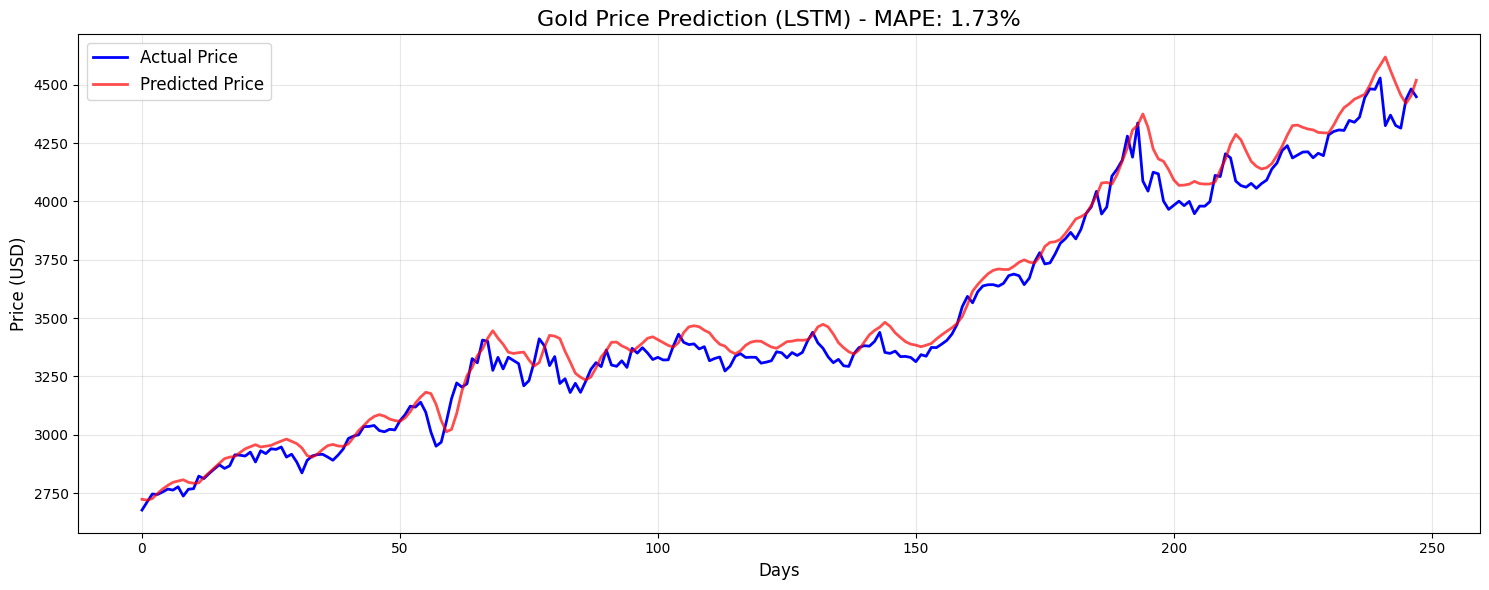

In [18]:
# STEP 8: VISUALIZE RESULTS
print("STEP 8: Visualizing Results")

# Plot predictions vs actual
plt.figure(figsize=(15, 6))
plt.plot(actual, label='Actual Price', color='blue', linewidth=2)
plt.plot(predictions, label='Predicted Price', color='red', linewidth=2, alpha=0.7)
plt.title(f'Gold Price Prediction (LSTM) - MAPE: {mape:.2f}%', fontsize=16)
plt.xlabel('Days', fontsize=12)
plt.ylabel('Price (USD)', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

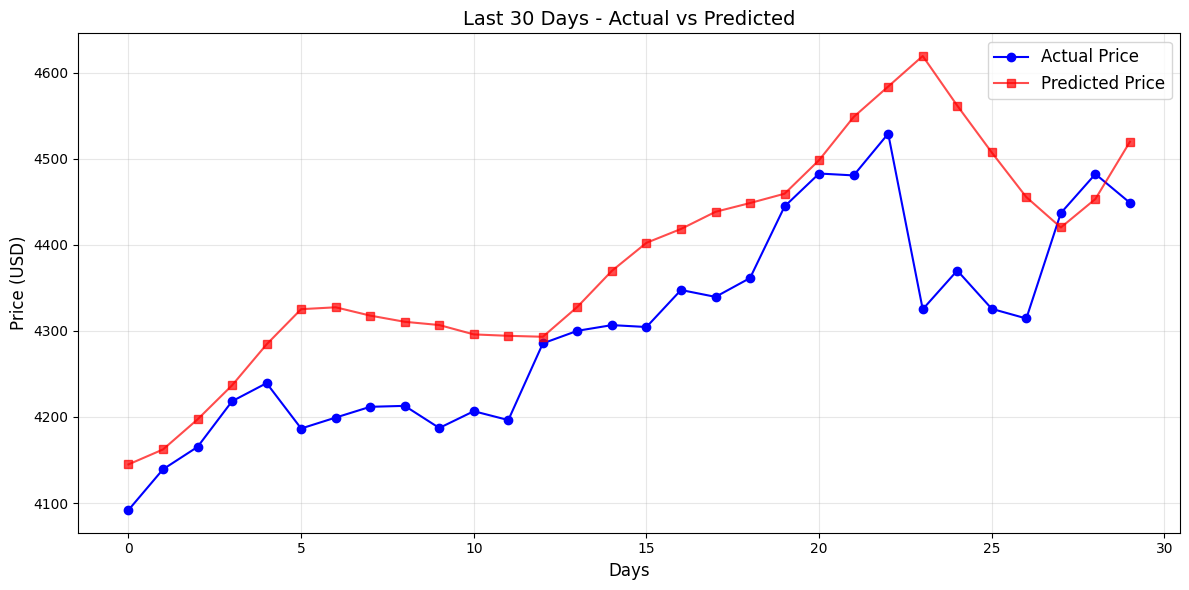

In [19]:
# Plot last 30 days for better visibility
plt.figure(figsize=(12, 6))
plt.plot(actual[-30:], label='Actual Price', marker='o', color='blue')
plt.plot(predictions[-30:], label='Predicted Price', marker='s', color='red', alpha=0.7)
plt.title('Last 30 Days - Actual vs Predicted', fontsize=14)
plt.xlabel('Days', fontsize=12)
plt.ylabel('Price (USD)', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [20]:
# STEP 9: SAVE MODEL FOR FLASK API
print("STEP 9: Saving Model for Flask API")

# Create models directory if it doesn't exist
os.makedirs('../models', exist_ok=True)

# Save model (using new .keras format)
model.save('../models/gold_lstm_model.keras')
print("✓ Saved model: ../models/gold_lstm_model.keras")

# Save scaler (needed for preprocessing new data)
joblib.dump(scaler, '../models/gold_scaler.pkl')
print("✓ Saved scaler: ../models/gold_scaler.pkl")

# Save metadata
metadata = {
    'lookback_days': LOOKBACK_DAYS,
    'mape': float(mape),
    'rmse': float(rmse),
    'direction_accuracy': float(direction_accuracy),
    'train_samples': len(X_train),
    'test_samples': len(X_test)
}

import json
with open('../models/model_metadata.json', 'w') as f:
    json.dump(metadata, f, indent=2)
print("✓ Saved metadata: ../models/model_metadata.json")

STEP 9: Saving Model for Flask API
✓ Saved model: ../models/gold_lstm_model.keras
✓ Saved scaler: ../models/gold_scaler.pkl
✓ Saved metadata: ../models/model_metadata.json


In [21]:
# TEST PREDICTION FUNCTION
print("Testing Prediction Function")

def predict_next_day(model, scaler, recent_data, lookback_days=20):
    """
    Predict next day's gold price
    This function will be used in Flask API!
    
    Args:
        model: Trained LSTM model
        scaler: Fitted scaler
        recent_data: Last N days of prices (numpy array)
        lookback_days: How many days to look back (default: 20)
    
    Returns:
        Predicted price for next day
    """
    # Scale the data
    scaled_data = scaler.transform(recent_data.reshape(-1, 1))
    
    # Get last lookback_days
    X_input = scaled_data[-lookback_days:].reshape(1, lookback_days, 1)
    
    # Predict
    prediction_scaled = model.predict(X_input, verbose=0)
    
    # Inverse transform to get actual price
    prediction = scaler.inverse_transform(prediction_scaled)
    
    return prediction[0][0]

# Test with last 20 days from our data
test_recent_data = prices[-LOOKBACK_DAYS:]
predicted_price = predict_next_day(model, scaler, test_recent_data, LOOKBACK_DAYS)

current_price = prices[-1][0]
change = predicted_price - current_price
change_pct = (change / current_price) * 100

print(f"\n🔮 PREDICTION TEST:")
print(f"Current Gold Price: ${current_price:.2f}")
print(f"Predicted Tomorrow: ${predicted_price:.2f}")
print(f"Expected Change: ${change:+.2f} ({change_pct:+.2f}%)")
print(f"Direction: {'UP 📈' if change > 0 else 'DOWN 📉'}")

print("\n✅ This function works! We'll use it in Flask API.")

Testing Prediction Function

🔮 PREDICTION TEST:
Current Gold Price: $4448.80
Predicted Tomorrow: $4563.50
Expected Change: $+114.70 (+2.58%)
Direction: UP 📈

✅ This function works! We'll use it in Flask API.
